In [2]:
import verde as vd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cartopy as ccrs

In [3]:
##5:GRID_EAST, 6:GRID_NORTH, 7:STATION_ELEV, 17:BOUGUER_ANOMALY
fp='./Data/landgrav_ss.csv'
dat=np.genfromtxt(fp,delimiter=",",skip_header=1,usecols=(5,6,17))
dat

array([[2.5880e+05, 5.5859e+05, 9.3300e+00],
       [2.4216e+05, 5.5831e+05, 1.0860e+01],
       [2.6052e+05, 5.4712e+05, 2.2930e+01],
       ...,
       [2.4324e+05, 6.1980e+05, 1.1390e+01],
       [2.3755e+05, 6.1583e+05, 1.6240e+01],
       [2.5383e+05, 6.3865e+05, 1.6210e+01]])

In [4]:
east = dat[:,0]
north = dat[:,1]
boug = dat[:,2]

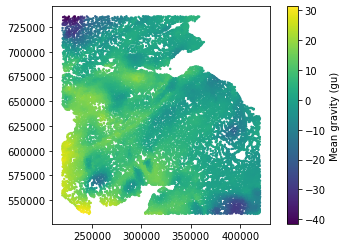

In [5]:
fig, ax = plt.subplots()
scatter = ax.scatter(east, north, c=boug, s=2)
ax.set_aspect('equal')
fig.colorbar(scatter, label='Mean gravity (gu)')

In [6]:
#Use Verde to make grid
nx = 256 #Number of points in x 
ny = 256 #Number of points in y
sqsize=180000   ### Size of square in metres
emin=220000     ### Easting of SW corner
emax=emin+sqsize
nmin=559000     ### Northing of SW corner
nmax=nmin+sqsize

W, E, S, N = 220000, 220000+180000, 559000, 559000+180000
region = (W, E, S, N)


In [7]:
easting, northing = vd.grid_coordinates(region = region, shape=(nx, ny))

In [8]:
#Interpolating the data
grd = vd.ScipyGridder(method='cubic').fit((east, north), boug)

In [9]:
#Gridding the data
grid = grd.grid(region = region, shape=(nx, ny), data_names='Gravity (gu)')

In [10]:
type(grid)

xarray.core.dataset.Dataset

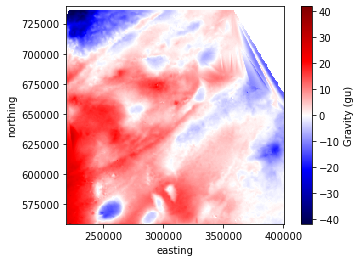

In [11]:
cmap = plt.cm.afmhot

fig, ax = plt.subplots()
grid['Gravity (gu)'].plot.pcolormesh(ax=ax, cmap='seismic')
ax.set_aspect('equal')


In [44]:
#mask based on the data being more then 2 grid spacings.
mask = vd.distance_mask(data_coordinates=(east, north), grid=grid, maxdist=5*(sqsize/nx))

Text(0.5, 1.0, 'Cubic interpolated Scotland Gravity data')

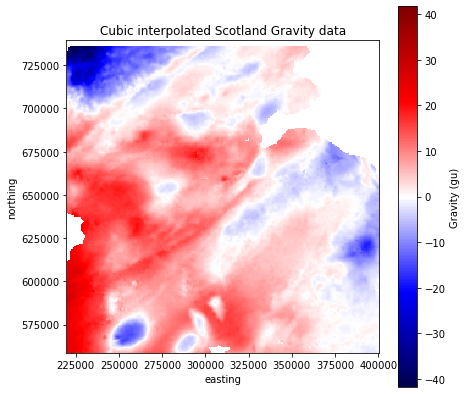

In [45]:
#Plot the masked data
fig, ax = plt.subplots(figsize=(7,7),)
mask['Gravity (gu)'].plot.pcolormesh(ax=ax, cmap='seismic')
ax.set_aspect('equal')
ax.set_title('Cubic interpolated Scotland Gravity data')


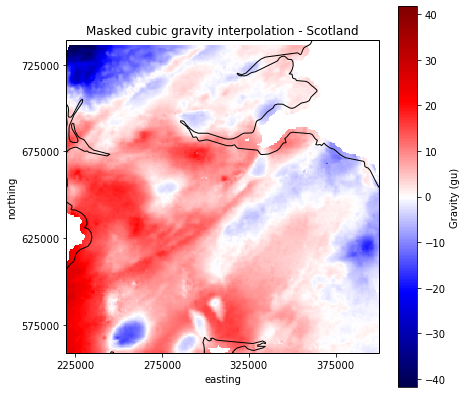

In [48]:
xticks = np.arange(225000, 400000, 50000)
yticks = np.arange(575000,775000, 50000)

fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.crs.OSGB())
mask['Gravity (gu)'].plot.pcolormesh(ax=ax, cmap='seismic')
ax.coastlines(resolution='10m')
ax.set_xlim((W, E))
ax.set_ylim((S, N))
ax.set_title('Masked cubic gravity interpolation - Scotland')
#ax.gridlines(crs=ccrs.crs.OSGB())

ax.set_xticks(xticks, minor=False)
ax.set_yticks(yticks, minor=False)

fp='./Figures/ScotlandGrav/cubic_interp.png'
fig.savefig(fp, dpi=300, bbox_inches='tight')

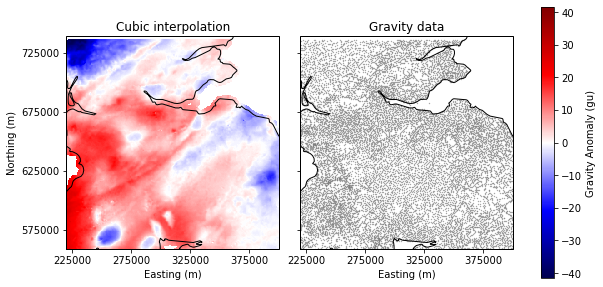

In [49]:
xticks = np.arange(225000, 400000, 50000)
yticks = np.arange(575000,775000, 50000)

fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw={'projection': ccrs.crs.OSGB()}, sharey=True, figsize=(10,5), sharex=True, gridspec_kw={'wspace': .1})
#ax1 = plt.axes(projection=ccrs.crs.OSGB())
plot = mask['Gravity (gu)'].plot.pcolormesh(ax=ax1, cmap='seismic', add_colorbar=False)
ax1.coastlines(resolution='10m')
ax1.set_xlim((W, E))
ax1.set_ylim((S, N))
ax1.set_title('Cubic interpolation')
ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.set_xlabel('Easting (m)')
ax1.set_ylabel('Northing (m)')
fig.colorbar(plot, ax=[ax1, ax2], label='Gravity Anomaly (gu)')


#ax2 = plt.axes(ax=ax2, projection=ccrs.crs.OSGB())
ax2.scatter(east, north, s=0.1, color='grey')
ax2.coastlines(resolution='10m')
ax2.set_xlim((W, E))
ax2.set_ylim((S, N))
ax2.set_xticks(xticks)
ax2.set_yticks(yticks)
ax2.set_xlabel('Easting (m)')
#ax2.set_ylabel('Northing (m)')
ax2.set_title('Gravity data')

fp='./Figures/ScotlandGrav/cubic_interp_data.png'
fig.savefig(fp, dpi=300, bbox_inches='tight')

In [50]:
def hill_shade(elev, altitude=45, azimuth=315):
    """Enter latitude and azimuth in degrees."""
    altitude = np.deg2rad(altitude)
    azimuth = np.deg2rad(azimuth)
    x, y = np.gradient(elev)
    slope = np.pi/2. - np.arctan(np.sqrt(x**2 + y**2))
    # Negative x because of pixel orders in the SRTM tile.
    aspect = np.arctan2(-x, y)

    shaded = (np.sin(altitude) * np.sin(slope) +
              np.cos(altitude) * np.cos(slope) *
              np.cos((azimuth - np.pi/2.) - aspect))
    return shaded

In [51]:
shaded = hill_shade(mask['Gravity (gu)'])

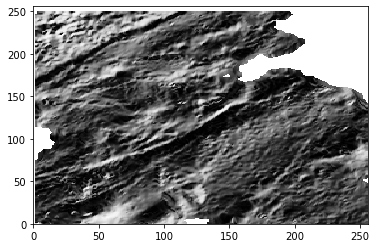

In [68]:
plt.pcolormesh(shaded, cmap='Greys')

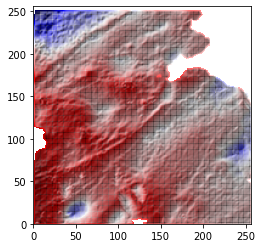

In [101]:
fig, ax = plt.subplots()
#mask['Gravity (gu)'].plot.pcolormesh(ax=ax, cmap='seismic', alpha=0.5)
ax.pcolormesh(mask['Gravity (gu)'], cmap = 'seismic')
ax.pcolormesh(shaded, cmap='Greys', alpha=0.15)
ax.set_aspect('equal')
#plt.show()